# Variational Autoencoder (VAE)

An autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.

In [4]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

## Hyperparameters

In [5]:
batch_size = 128
learning_rate = 0.001
num_epochs = 10

## MNIST

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1
)

## Model

In [7]:
from utils import VAE

imgChannels = 1
featureDim = 32 * 20 * 20
zDim = 4

model = VAE(imgChannels, featureDim, zDim).to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate
)


### Training

Denoising Autoencoder takes a noisy image as input and the target for the output layer is the original input without noise.

In [2]:
def add_noise(inputs, noise_factor = 0.3):
     noisy = inputs + torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [16]:
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):

        imgs, _ = data
        imgs = add_noise(imgs, 0.3)
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = model(imgs)

        # For Generating is better KL
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        # kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        # loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

        # For Denoising is better MSE
        loss = F.mse_loss(out, imgs)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

Epoch 0: Loss 0.054511114954948425
Epoch 1: Loss 0.05335654690861702
Epoch 2: Loss 0.05354513227939606
Epoch 3: Loss 0.05390011519193649
Epoch 4: Loss 0.05384082347154617
Epoch 5: Loss 0.0531904362142086
Epoch 6: Loss 0.053609929978847504
Epoch 7: Loss 0.05329311639070511
Epoch 8: Loss 0.05254736915230751
Epoch 9: Loss 0.053205475211143494


## Visualization and Evaluation

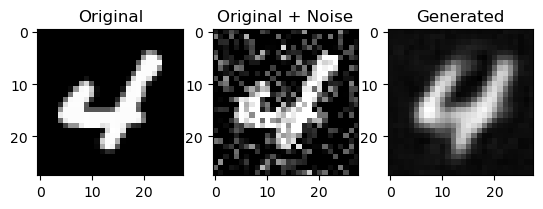

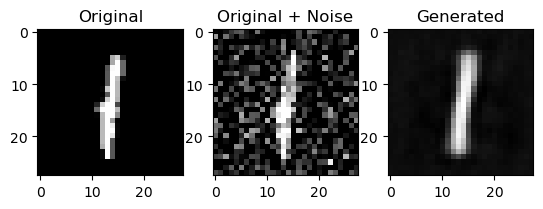

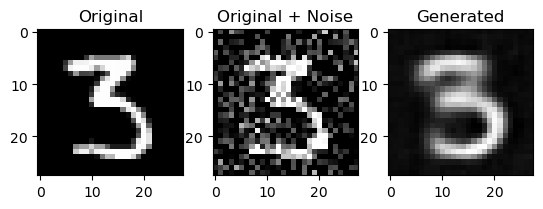

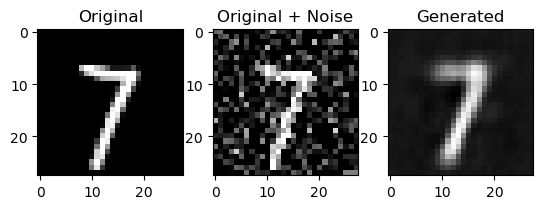

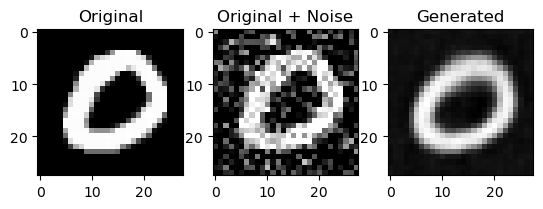

In [18]:
model.eval()
imgs_to_show = 5

with torch.no_grad():
    for data in random.sample(list(test_loader), imgs_to_show):
        
        # Original
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(131)
        plt.title("Original")
        plt.imshow(np.squeeze(img), cmap='gray')

        # Original + Noise
        imgs, _ = data
        imgs = add_noise(imgs, 0.3)
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(132)
        plt.title("Original + Noise")
        plt.imshow(np.squeeze(img), cmap='gray')

        # Generated
        out, mu, logVAR = model(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(133)
        plt.imshow(np.squeeze(outimg), cmap='gray')
        plt.title("Generated")
        plt.show()